In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from adaptive_sampling.processing_tools.utils import *
from adaptive_sampling.units import *

In [2]:
def double_well_potential(coord_x, coord_y):
    """ Analytical double well potential
    """
    a = 8.0e-6
    b = 0.5
    d = 80.0
    e = 160.0

    s1 = (coord_x-d)*(coord_x-d)
    s2 = (coord_x-e)*(coord_x-e)

    return a * s1*s2 + b*coord_y*coord_y

coords_x = np.arange(60,181,1.0)
coords_y = np.arange(-8,8,0.1)
xx,yy = np.meshgrid(coords_x,coords_y)

PES = double_well_potential(xx,yy)

In [3]:
def plot_potential(axs, xx, yy, PES):

    # calculate the potential energy surface
    coords_x = np.arange(60,181,1.0)
    coords_y = np.arange(-8,8,0.1)
    xx,yy = np.meshgrid(coords_x,coords_y)

    PES = double_well_potential(xx,yy)
    
    # plot the potential energy surface
    CS = axs.contour(xx, yy, PES, colors='black', levels=12, linewidths=2.5, zorder=1)
    plt.clabel(CS, CS.levels, inline='true', fontsize=25, fmt="%5.3f")
    axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
    axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
    axs.set_ylabel('y / \AA', fontsize=40)
    axs.set_xlabel('x / \AA', fontsize=40)
    axs.set_xlim([70,170])
    axs.set_ylim([-5,5])

    axs.spines['bottom'].set_linewidth(3)
    axs.spines['top'].set_linewidth(3)
    axs.spines['left'].set_linewidth(3)
    axs.spines['right'].set_linewidth(3)
    return axs

KeyboardInterrupt: 

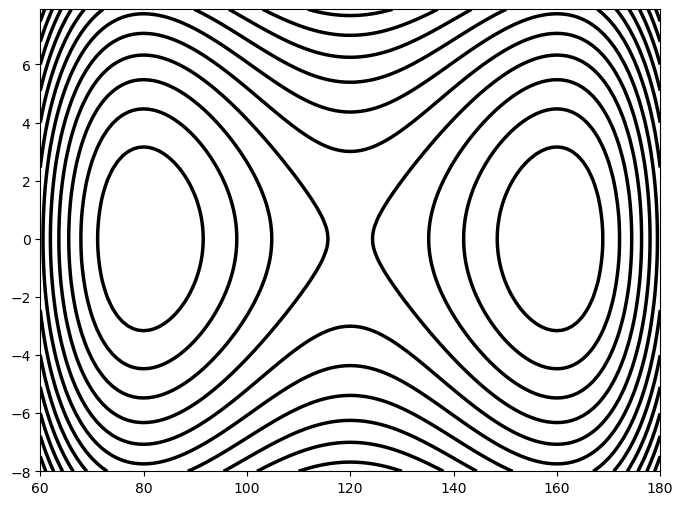

In [4]:
plt.rcParams["figure.figsize"] = [8,6]
fig, axs = plt.subplots(ncols=1)

axs = plot_potential(axs, xx, yy, PES)

axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
from adaptive_sampling.sampling_tools.metadynamics_refactured import WTM
from adaptive_sampling.interface.interfaceMD_2D import MD

# ------------------------------------------------------------------------------------
# MD Parameters

nsteps = 1e5  # number of steps
traj_freq = 10  # frequency of writing trajectory
print_freq = 1000  # frequency of printing output
biased = True  # enables biased simulation

# ------------------------------------------------------------------------------------
# Setup CV

# remove old output
if os.path.isfile("CV_traj.dat"):
    print("Removing old trajectory")
    os.system("rm CV_traj.dat")
if os.path.isfile("restart_mtd.npz"):
    os.system("rm restart_mtd.npz")

cv_atoms = []  # not needed for 2D potentials
min_1 = 60  # minimum of CV 1
max_1 = 180  # maximum of CV 1
bin_width_1 = 1.0  # bin width along CV 1
min_2 = -1.5  # minimum of CV 2
max_2 = 1.5  # minimum of CV 2
bin_width_2 = 0.05  # bin width along CV 2

collective_var = [
    ["x", cv_atoms, min_1, max_1, bin_width_1],
    #    ["y", cv_atoms, min_2, max_2, bin_width_2],
]

periodicity = [None]

grid_1 = np.arange(min_1, max_1, bin_width_1)
grid_2 = np.arange(min_2, max_2, bin_width_2)

# ------------------------------------------------------------------------------------
# Setup MD
mass = 10.0  # mass of particle in a.u.
seed = np.random.randint(1000)  # random seed
dt = 1.0e0  # stepsize in fs
temp = 300.0  # temperature in K

coords_in = [np.random.normal(70, 5), np.random.normal(0, 1)]
print(f" >>> Starting MD from {coords_in}")

the_md = MD(
    mass_in=mass,
    coords_in=coords_in,
    potential="1",
    dt_in=dt,
    target_temp_in=temp,
    seed_in=seed,
)
the_md.calc_init()
the_md.calc_etvp()

# --------------------------------------------------------------------------------------
# Setup the sampling algorithm
well_tempered_temp = None
hill_std = 5.0  # OPES hill width
hill_height = 20.0
bias_factor = 15  # OPES Bias factor gamma
update_frequency = 200  # OPES frequency of hill creation

the_bias = WTM(
    hill_height,
    hill_std,
    the_md,
    collective_var,
    bias_factor=bias_factor,
    hill_drop_freq=update_frequency,
    periodicity=periodicity,
    well_tempered_temp=well_tempered_temp,
    force_from_grid=False,
    equil_temp=temp,  # equilibrium temperature of simulation
    kinetics=True,  # calculate importent metrics to get accurate kinetics
    verbose=True,  # print verbose output
)
the_bias.step_bias()


1.0
Removing old trajectory
 >>> Starting MD from [61.27116126852326, 0.6701272578978174]
THE RANDOM NUMBER SEED WAS: 154

 >>> INFO: Initialize x as collective variable:
	 Minimum0:	60.0 
	 Maximum0:	180.0 
	 Bin width0:	1.0 
	----------------------------------------------
	 Total number of bins:		120

 >>> INFO: MtD Parameters:
	 ---------------------------------------------
	 Hill std:	[5.]
	 Hill height:	20.0 kJ/mol
	 Bias factor:	15 (WTM temperature: 4200.0 K)
	 Read force:	False
	 ---------------------------------------------


>>> adaptive-sampling: Module 'ase' not found, will not import 'FENEB'
>>> adaptive-sampling: Module 'ase' not found, will not import 'FENEB'


array([0., 0.])

In [ ]:
def print_output(the_md, the_bias):
    print(
        "%11.2f\t%14.6f\t%14.6f\t%14.6f\t%14.6f\t%14.6f\t%14.6f"
        % (
            the_md.step * the_md.dt * atomic_to_fs,
            the_md.coords[0],
            the_md.coords[1],
            the_md.epot,
            the_md.ekin,
            the_md.epot + the_md.ekin,
            the_md.temp,
        )
    )
    sys.stdout.flush()

In [ ]:
print(
    "%11s\t%14s\t%14s\t%14s\t%14s\t%14s\t%14s"
    % ("time [fs]","x","y","E_pot","E_kin","E_tot","Temp")
    )
x_traj,y_traj = [],[]
while the_md.step < nsteps:
    the_md.step += 1

    the_md.propagate(langevin=True)
    the_md.calc()

    if biased:
        the_md.forces += the_bias.step_bias()

    the_md.up_momenta(langevin=True)
    the_md.calc_etvp()

    if the_md.step % print_freq == 0:
        print_output(the_md, the_bias)
    if the_md.step % traj_freq == 0:
        x_traj.append(the_md.coords[0])
        y_traj.append(the_md.coords[1])

  time [fs]	             x	             y	         E_pot	         E_kin	         E_tot	          Temp
    1000.00	    101.924990	      0.785067	      0.005057	      0.016279	      0.021336	  10280.844842
    2000.00	    160.684877	     -2.187284	      0.000920	      0.019187	      0.020108	  12117.831758
    3000.00	    185.179540	     -1.105969	      0.021604	      0.013276	      0.034881	   8384.573355
    4000.00	    104.670340	     -1.868507	      0.006342	      0.027519	      0.033862	  17379.843494
    5000.00	     47.722089	      0.844787	      0.040156	      0.005825	      0.045981	   3679.063130
    6000.00	    100.278622	     -0.468499	      0.004511	      0.026386	      0.030897	  16663.943432
    7000.00	    166.019637	     -0.764322	      0.000928	      0.029049	      0.029978	  18346.146448
    8000.00	    151.240468	     -0.460104	      0.001227	      0.019513	      0.020740	  12323.527001
    9000.00	     93.545782	     -0.632023	      0.002545	      0.026735	      0.02

In [ ]:
cv_traj = np.loadtxt('CV_traj.dat', skiprows=1)
cv_time = cv_traj[:,0]
cv_x = cv_traj[:,1]
cv_pot = cv_traj[:,4]
print(cv_pot)

[0.007618 0.007618 0.007618 ... 0.252124 0.252175 0.252238]


TypeError: object of type 'numpy.float64' has no len()

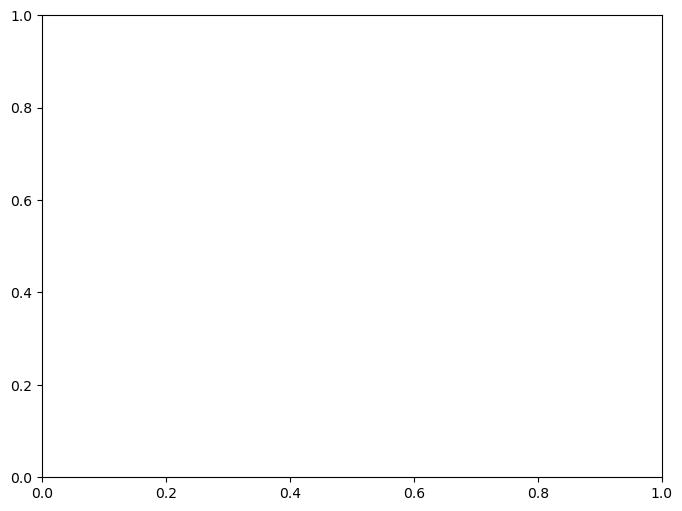

In [ ]:
plt.rcParams["figure.figsize"] = [8,6]
fig, axs = plt.subplots(ncols=1)

# plot the data points
t = np.arange(len(x_traj))
plt.scatter(x_traj,y_traj, s=1, c=t, cmap='autumn', zorder=0)

# plot the potential energy surface
CS = axs.contour(xx, yy, PES, colors='black', levels=12, linewidths=2.5, zorder=1)
plt.clabel(CS, CS.levels, inline='true', fontsize=20, fmt="%5.3f")
axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.set_ylabel('y / \AA', fontsize=40)
axs.set_xlabel('x / \AA', fontsize=40)
axs.set_xlim([70,170])
axs.set_ylim([-5,5])

axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

#plt.savefig("sampling_double_well_pot.pdf")
plt.show()
plt.close()

In [5]:
beta = 1.0 / (kB_in_SI * 300.0)
dx = grid_1[1] - grid_1[0]
dx2 = dx / 2.0
pmf_hist_res = 10
n = int(len(cv_x)/pmf_hist_res)
scattered_time = []
pmf_hist = []
print("Initialize.")
for j in range(pmf_hist_res):
    n_sample = j * n + n
    print("Iteration ",j+1," of", pmf_hist_res, "started.")
    scattered_time.append(n_sample)
    potential = np.zeros_like(grid_1)
    for i,x in enumerate(grid_1): # Loop over grid so that i are bin centers
        indices_hist = np.where(np.logical_and((cv_x[0:n_sample] >= x - dx2), (cv_x[0:n_sample] < x + dx2)))
        potential[i] = np.sum(np.exp(-beta * cv_pot[indices_hist]))
    #potential /= potential.sum()
    potential -= potential.min()
    potential = np.where(potential==np.inf, 0, potential)
    pmf_hist.append(potential)
print("Done.")
pmf_bin = pmf_hist[-1]

NameError: name 'grid_1' is not defined